In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from scipy import stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement_ref = Base.classes.measurement
station_ref = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#Find the last date in the database
last_date = session.query(measurement_ref.date).order_by(measurement_ref.date.desc()).first()
last_date[0]

'2017-08-23'

In [11]:
# Calculate the date 1 year ago (i.e., 12 months)

query_date = dt.date(2017, 8, 23) - dt.timedelta(weeks=52)
query_date

datetime.date(2016, 8, 24)

In [12]:
# Query for date and precipitation

last_12_months = session.query(measurement_ref.date, measurement_ref.prcp).\
    filter(measurement_ref.date >= query_date).all()

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column

precip_df = pd.DataFrame(last_12_months)
precip_df = precip_df.set_index("date")
precip_df

prcp
date            
2016-08-24  0.08
2016-08-25  0.08
2016-08-26  0.00
2016-08-27  0.00
2016-08-28  0.01
...          ...
2017-08-19  0.09
2017-08-20   NaN
2017-08-21  0.56
2017-08-22  0.50
2017-08-23  0.45

[2223 rows x 1 columns]

In [14]:
# Sort the dataframe by date
precip_df = precip_df.sort_values("date")
precip_df

prcp
date            
2016-08-24  0.08
2016-08-24   NaN
2016-08-24  2.15
2016-08-24  2.28
2016-08-24  2.15
...          ...
2017-08-22  0.00
2017-08-23  0.08
2017-08-23  0.00
2017-08-23  0.00
2017-08-23  0.45

[2223 rows x 1 columns]

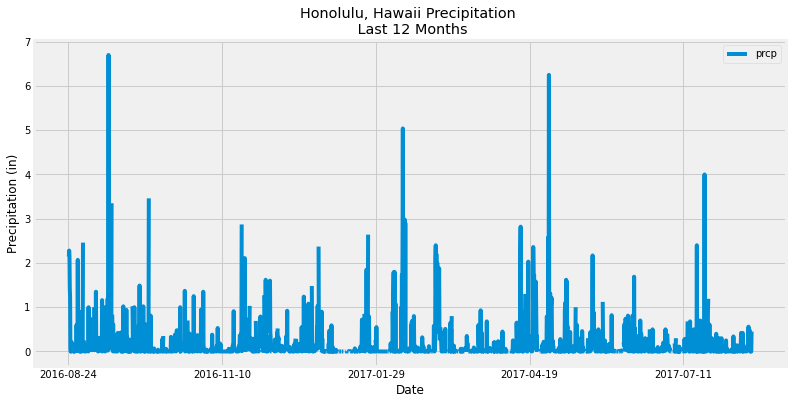

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("Precipitation (in)")
plt.title("Honolulu, Hawaii Precipitation \n Last 12 Months")
plt.savefig("images/hon_hawaii_precip_timeseries.jpeg")

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data

summary_precip_df = precip_df.groupby("date").agg({"prcp": ["mean", "median", "var", "std", "sem"]})
summary_precip_df

prcp                                     
                mean median       var       std       sem
date                                                     
2016-08-24  1.555000  1.800  0.706510  0.840541  0.343150
2016-08-25  0.077143  0.080  0.005157  0.071813  0.027143
2016-08-26  0.016667  0.015  0.000267  0.016330  0.006667
2016-08-27  0.064000  0.020  0.006680  0.081731  0.036551
2016-08-28  0.516667  0.140  0.620427  0.787672  0.321566
...              ...    ...       ...       ...       ...
2017-08-19  0.030000  0.000  0.002700  0.051962  0.030000
2017-08-20  0.005000  0.005  0.000050  0.007071  0.005000
2017-08-21  0.193333  0.020  0.100933  0.317700  0.183424
2017-08-22  0.166667  0.000  0.083333  0.288675  0.166667
2017-08-23  0.132500  0.040  0.046225  0.215000  0.107500

[365 rows x 5 columns]

In [17]:
# Design a query to show how many stations are available in this dataset?
count_stations = session.query(func.count(station_ref.station)).all()
print(f"There are {count_stations[0][0]} unique station IDs.")

There are 9 unique station IDs.


In [18]:
first_row_1 = session.query(station_ref).first()
first_row_1.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x23ba5facc88>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?

grouped_station_count = session.query(measurement_ref.station, func.count(measurement_ref.station)).group_by(measurement_ref.station).all()
grouped_station_count

[('USC00511918', 1979),
 ('USC00513117', 2709),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00517948', 1372),
 ('USC00518838', 511),
 ('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00519523', 2669)]

In [20]:
# List the stations and the counts in descending order.
ordered_stations = session.query(measurement_ref.station, func.count(measurement_ref.station)).order_by(func.count(measurement_ref.station).desc()).group_by(measurement_ref.station).all()

station_list = []

for station in ordered_stations:
    print(station[0], station[1])

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded
min_temp = session.query(func.min(measurement_ref.tobs)).filter(measurement_ref.station == "USC00519281").all()

for temp in min_temp:
    print(f"The lowest temperature recorded was {temp[0]}.")

The lowest temperature recorded was 54.0.


In [22]:
# highest temperature recorded, and average temperature of the most active station?
max_temp = session.query(func.max(measurement_ref.tobs)).filter(measurement_ref.station == "USC00519281").all()

for temp in max_temp:
    print(f"The highest temperature recorded was {temp[0]}.")

The highest temperature recorded was 85.0.


In [23]:
# Choose the station with the highest number of temperature observations.
all_temp_records = session.query(measurement_ref.station, func.count(measurement_ref.tobs)).\
                    order_by(func.count(measurement_ref.tobs).desc()).group_by(measurement_ref.station).first()

all_temp_records

('USC00519281', 2772)

In [24]:
most_temp_recs = session.query(measurement_ref.date, measurement_ref.tobs).filter(measurement_ref.station == 'USC00519281').all()
most_temp_recs

[('2010-01-01', 70.0),
 ('2010-01-02', 62.0),
 ('2010-01-03', 74.0),
 ('2010-01-04', 75.0),
 ('2010-01-05', 74.0),
 ('2010-01-06', 76.0),
 ('2010-01-07', 69.0),
 ('2010-01-08', 66.0),
 ('2010-01-09', 70.0),
 ('2010-01-10', 75.0),
 ('2010-01-11', 64.0),
 ('2010-01-12', 60.0),
 ('2010-01-13', 61.0),
 ('2010-01-14', 68.0),
 ('2010-01-15', 64.0),
 ('2010-01-16', 66.0),
 ('2010-01-17', 67.0),
 ('2010-01-18', 70.0),
 ('2010-01-19', 67.0),
 ('2010-01-20', 67.0),
 ('2010-01-21', 69.0),
 ('2010-01-22', 60.0),
 ('2010-01-23', 75.0),
 ('2010-01-24', 75.0),
 ('2010-01-25', 65.0),
 ('2010-01-26', 75.0),
 ('2010-01-27', 69.0),
 ('2010-01-28', 67.0),
 ('2010-01-29', 66.0),
 ('2010-01-30', 69.0),
 ('2010-01-31', 72.0),
 ('2010-02-01', 67.0),
 ('2010-02-02', 65.0),
 ('2010-02-03', 64.0),
 ('2010-02-04', 67.0),
 ('2010-02-05', 67.0),
 ('2010-02-06', 68.0),
 ('2010-02-07', 69.0),
 ('2010-02-08', 66.0),
 ('2010-02-09', 69.0),
 ('2010-02-10', 61.0),
 ('2010-02-11', 71.0),
 ('2010-02-12', 70.0),
 ('2010-02-

In [25]:
station_USC00519281_df = pd.DataFrame(most_temp_recs)

In [26]:
station_USC00519281_df = station_USC00519281_df.set_index("date")

In [27]:
station_USC00519281_df

tobs
date            
2010-01-01  70.0
2010-01-02  62.0
2010-01-03  74.0
2010-01-04  75.0
2010-01-05  74.0
...          ...
2017-08-14  77.0
2017-08-15  77.0
2017-08-16  76.0
2017-08-17  76.0
2017-08-18  79.0

[2772 rows x 1 columns]

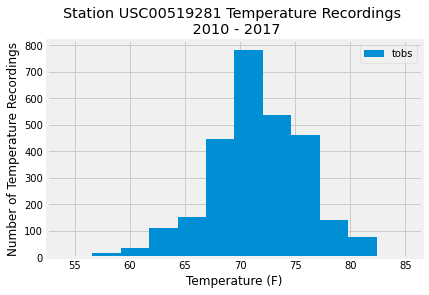

In [28]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_USC00519281_df.plot(kind="hist", bins=12)
plt.title("Station USC00519281 Temperature Recordings \n 2010 - 2017")
plt.xlabel("Temperature (F)")
plt.ylabel("Number of Temperature Recordings")
plt.savefig("images/station_USC00519281_temp_recordings.jpeg")

## Bonus Challenge Assignment

### Temperature Analysis I

In [29]:
june = "06"
december = "12"

In [30]:
june_query = session.query(measurement_ref.tobs).filter(func.strftime("%m", measurement_ref.date) == june).all()
december_query = session.query(measurement_ref.tobs).filter(func.strftime("%m", measurement_ref.date) == december).all()

In [31]:
june_query

[(78.0),
 (76.0),
 (78.0),
 (76.0),
 (77.0),
 (78.0),
 (77.0),
 (78.0),
 (78.0),
 (79.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (78.0),
 (78.0),
 (77.0),
 (77.0),
 (82.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (76.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (78.0),
 (73.0),
 (70.0),
 (76.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (78.0),
 (77.0),
 (77.0),
 (78.0),
 (78.0),
 (77.0),
 (78.0),
 (78.0),
 (75.0),
 (76.0),
 (76.0),
 (77.0),
 (78.0),
 (76.0),
 (77.0),
 (75.0),
 (77.0),
 (76.0),
 (76.0),
 (75.0),
 (77.0),
 (77.0),
 (76.0),
 (78.0),
 (77.0),
 (76.0),
 (77.0),
 (76.0),
 (76.0),
 (77.0),
 (77.0),
 (78.0),
 (77.0),
 (77.0),
 (77.0),
 (76.0),
 (75.0),
 (76.0),
 (76.0),
 (77.0),
 (76.0),
 (73.0),
 (73.0),
 (75.0),
 (77.0),
 (76.0),
 (77.0),
 (79.0),
 (78.0),
 (79.0),
 (78.0),
 (78.0),
 (79.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (78.0),
 (77.0),
 (76.0),
 (78.0),
 (78.0),
 (77.0),
 (78.0),
 (78.0),
 (73.0),
 (76.0),
 (77.0),
 (75.0),
 (76.0),
 (74.0),
 

In [32]:
t_test = stats.ttest_ind(june_query, december_query, nan_policy='omit')

In [33]:
t_test

Ttest_indResult(statistic=array([31.60372399]), pvalue=array([3.9025129e-191]))

### Findings

The t-stat and p-value both point to the means being different, meaning there is strong evidence that the mean temperatures for June and December are indeed different. 

### Temperature Analysis II

In [34]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement_ref.tobs), func.avg(measurement_ref.tobs), func.max(measurement_ref.tobs)).\
        filter(measurement_ref.date >= start_date).filter(measurement_ref.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [35]:
# Use function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
this_year = calc_temps('2017-01-01', '2017-01-20')
prev_year = calc_temps('2016-01-01', '2016-01-20')

In [36]:
this_year_list = list(np.ravel(this_year))
this_year_list

[60.0, 69.49180327868852, 81.0]

In [37]:
prev_year_list = list(np.ravel(prev_year))
prev_year_list

[61.0, 69.34745762711864, 78.0]

In [38]:
this_year_err = (this_year_list[2] - this_year_list[0])
this_year_err

21.0

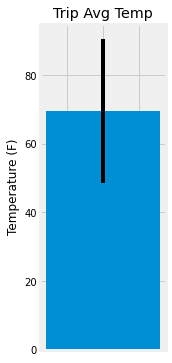

In [39]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(2, 6))
plt.bar(1, this_year_list[1])
plt.errorbar(1, this_year_list[1], yerr=this_year_err, color='black')
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F)")
plt.savefig("images/trip_avg_temp.jpeg")

In [40]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
prev_year = calc_temps('2016-01-01', '2016-01-20')

prev_year_rain = session.query(measurement_ref.station, station_ref.latitude, station_ref.longitude, station_ref.elevation, func.sum(measurement_ref.prcp)).\
                group_by(measurement_ref.station).\
                filter(measurement_ref.date >= '2016-01-01').filter(measurement_ref.date <= '2016-01-20').filter(station_ref.station == measurement_ref.station).all()

In [41]:
prev_year_rain

[('USC00513117', 21.4234, -157.8015, 14.6, 0.6800000000000002),
 ('USC00514830', 21.5213, -157.8374, 7.0, 0.7900000000000001),
 ('USC00516128', 21.3331, -157.8025, 152.4, 2.95),
 ('USC00517948', 21.3934, -157.9751, 11.9, 0.0),
 ('USC00519281', 21.45167, -157.84888999999998, 32.9, 1.09),
 ('USC00519397', 21.2716, -157.8168, 3.0, 0.24000000000000002),
 ('USC00519523', 21.33556, -157.71139, 19.5, 0.13)]

In [42]:
prev_year_df = pd.DataFrame(prev_year_rain, columns = ["Station", "Lat", "Lon", "Elevation", "Prcp"])

In [43]:
prev_year_df = prev_year_df.sort_values("Prcp", ascending=False)

In [44]:
prev_year_df = prev_year_df.set_index("Station")

In [45]:
prev_year_df 

Lat        Lon  Elevation  Prcp
Station                                          
USC00516128  21.33310 -157.80250      152.4  2.95
USC00519281  21.45167 -157.84889       32.9  1.09
USC00514830  21.52130 -157.83740        7.0  0.79
USC00513117  21.42340 -157.80150       14.6  0.68
USC00519397  21.27160 -157.81680        3.0  0.24
USC00519523  21.33556 -157.71139       19.5  0.13
USC00517948  21.39340 -157.97510       11.9  0.00

In [226]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement_ref.tobs), func.avg(measurement_ref.tobs), func.max(measurement_ref.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement_ref.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [227]:
# Set the start and end date of the trip
start_date = dt.date(2016, 1, 1)
end_date = dt.date(2016, 1, 20)

In [228]:
# Use the start and end date to create a range of dates
dates = []
trip_days = []

while start_date <= end_date:
    dates.append(start_date)
    start_date += dt.timedelta(days=1)

# Stip off the year and save a list of %m-%d strings
for date in dates:
    change = dt.datetime.strftime(date, "%m-%d")
    trip_days.append(change)
    

In [229]:
trip_days

['01-01',
 '01-02',
 '01-03',
 '01-04',
 '01-05',
 '01-06',
 '01-07',
 '01-08',
 '01-09',
 '01-10',
 '01-11',
 '01-12',
 '01-13',
 '01-14',
 '01-15',
 '01-16',
 '01-17',
 '01-18',
 '01-19',
 '01-20']

In [230]:
# calculate the daily normals for your trip (i.e., '2016-01-01', '2016-01-20')
# Loop through the list of %m-%d strings and calculate the normals for each date

daily_norms_list = []
daily_dict = {}

for date in trip_days:
    daily_calc = daily_normals(f"{date}")
    daily_norms_list.append(daily_calc)
    d_min = daily_calc[0][0]
    d_avg = daily_calc[0][1]
    d_max = daily_calc[0][2]
    daily_dict[f"{date}"] = [d_min, d_avg, d_max]

In [231]:
daily_dict

{'01-01': [62.0, 69.15384615384616, 77.0],
 '01-02': [60.0, 69.39622641509433, 77.0],
 '01-03': [62.0, 68.9090909090909, 77.0],
 '01-04': [58.0, 70.0, 76.0],
 '01-05': [56.0, 67.96428571428571, 76.0],
 '01-06': [61.0, 68.96491228070175, 76.0],
 '01-07': [57.0, 68.54385964912281, 76.0],
 '01-08': [57.0, 67.16071428571429, 75.0],
 '01-09': [58.0, 67.9298245614035, 78.0],
 '01-10': [62.0, 69.74137931034483, 77.0],
 '01-11': [57.0, 67.3103448275862, 78.0],
 '01-12': [57.0, 67.4074074074074, 81.0],
 '01-13': [57.0, 67.25454545454545, 77.0],
 '01-14': [58.0, 69.52631578947368, 77.0],
 '01-15': [56.0, 69.31372549019608, 78.0],
 '01-16': [54.0, 68.62962962962963, 80.0],
 '01-17': [61.0, 69.07407407407408, 76.0],
 '01-18': [57.0, 68.63157894736842, 77.0],
 '01-19': [60.0, 68.26315789473684, 78.0],
 '01-20': [61.0, 68.86666666666666, 78.0]}

In [232]:
daily_df = pd.DataFrame(daily_dict).T

In [233]:
daily_df = daily_df.rename(columns={0: "Min Temp", 1: "Avg Temp", 2: "Max Temp"})

In [234]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_df

Min Temp   Avg Temp  Max Temp
01-01      62.0  69.153846      77.0
01-02      60.0  69.396226      77.0
01-03      62.0  68.909091      77.0
01-04      58.0  70.000000      76.0
01-05      56.0  67.964286      76.0
01-06      61.0  68.964912      76.0
01-07      57.0  68.543860      76.0
01-08      57.0  67.160714      75.0
01-09      58.0  67.929825      78.0
01-10      62.0  69.741379      77.0
01-11      57.0  67.310345      78.0
01-12      57.0  67.407407      81.0
01-13      57.0  67.254545      77.0
01-14      58.0  69.526316      77.0
01-15      56.0  69.313725      78.0
01-16      54.0  68.629630      80.0
01-17      61.0  69.074074      76.0
01-18      57.0  68.631579      77.0
01-19      60.0  68.263158      78.0
01-20      61.0  68.866667      78.0

<AxesSubplot:>

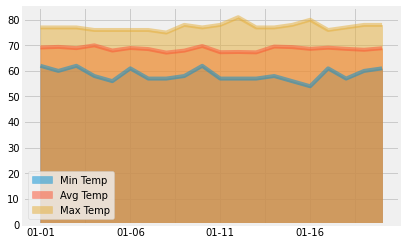

In [163]:
# Plot the daily normals as an area plot with `stacked=False`
daily_df.plot(kind="area", stacked=False)